In [ ]:
pip install seaborn

In [18]:
import pyodbc
import pandas as pd
from azure.identity import DefaultAzureCredential
from azure.keyvault.secrets import SecretClient
from datetime import datetime, timedelta

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def get_secret():
    credential = DefaultAzureCredential()
    secret_client = SecretClient(vault_url="https://kvsynapsedata001.vault.azure.net", credential=credential)
    secret = secret_client.get_secret("pw-SRVSQLPoolSQL")
    return secret.value
 
 
server = 'tcp:arriba-synapseworkspace-prod-ae-001.sql.azuresynapse.net,1433'
database = 'arribasqlpool1'
username = 'SRV_SQLPool_SQL'
password = get_secret()  
 
otheropts = 'Encrypt=yes;TrustServerCertificate=yes;Connection Timeout=30;'
 
 
cnxn_t = pyodbc.connect('DRIVER={ODBC Driver 18 for SQL Server};SERVER='+server+';DATABASE='+database+';UID='+username+';PWD='+password+';'+otheropts)
cursor_t = cnxn_t.cursor()
 
 
 
 

##### Sample Queries

##### AB tables from JRL

In [8]:
queries = {
    "ab_sp_df": "SELECT * FROM [aimbig].[stream_participants]",
    "ab_j_df": "SELECT * FROM [aimbig].[jobseekers]",
    "ab_rs_df": "SELECT * FROM [aimbig].[referral_sources]",
    "ab_u_df": "SELECT * FROM [aimbig].[users]"
}

# 执行查询并存入字典
dfs = {name: pd.read_sql(query, cnxn_t) for name, query in queries.items()}

# 保存文件
for name, df in dfs.items():
    csv_filename = name.replace("_df", "") + ".csv"
    df.to_csv(csv_filename, index=False)


print("所有 DataFrame 已保存为 Parquet 文件。")


/tmp/ipykernel_37501/502317515.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dfs = {name: pd.read_sql(query, cnxn_t) for name, query in queries.items()}
/tmp/ipykernel_37501/502317515.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dfs = {name: pd.read_sql(query, cnxn_t) for name, query in queries.items()}
/tmp/ipykernel_37501/502317515.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dfs = {name: pd.read_sql(query, cnxn_t) for name, query in queries.items()}
/tmp/ipykernel_37501/502317515.py:9: UserWarning: pa

所有 DataFrame 已保存为 Parquet 文件。


In [94]:
ab_j_df = pd.read_csv("ab_j.csv")
ab_u_df = pd.read_csv("ab_u.csv")
ab_sp_df = pd.read_csv("ab_sp.csv")
ab_rs_df = pd.read_csv("ab_rs.csv")

/tmp/ipykernel_81604/2880292732.py:1: DtypeWarning: Columns (2,21) have mixed types. Specify dtype option on import or set low_memory=False.
  ab_j_df = pd.read_csv("ab_j.csv")


In [95]:
ab_rs_df.shape

(17, 7)

/tmp/ipykernel_81604/1944586383.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_nulls_df, x='NullCountx', y='Column', palette='Blues_r')


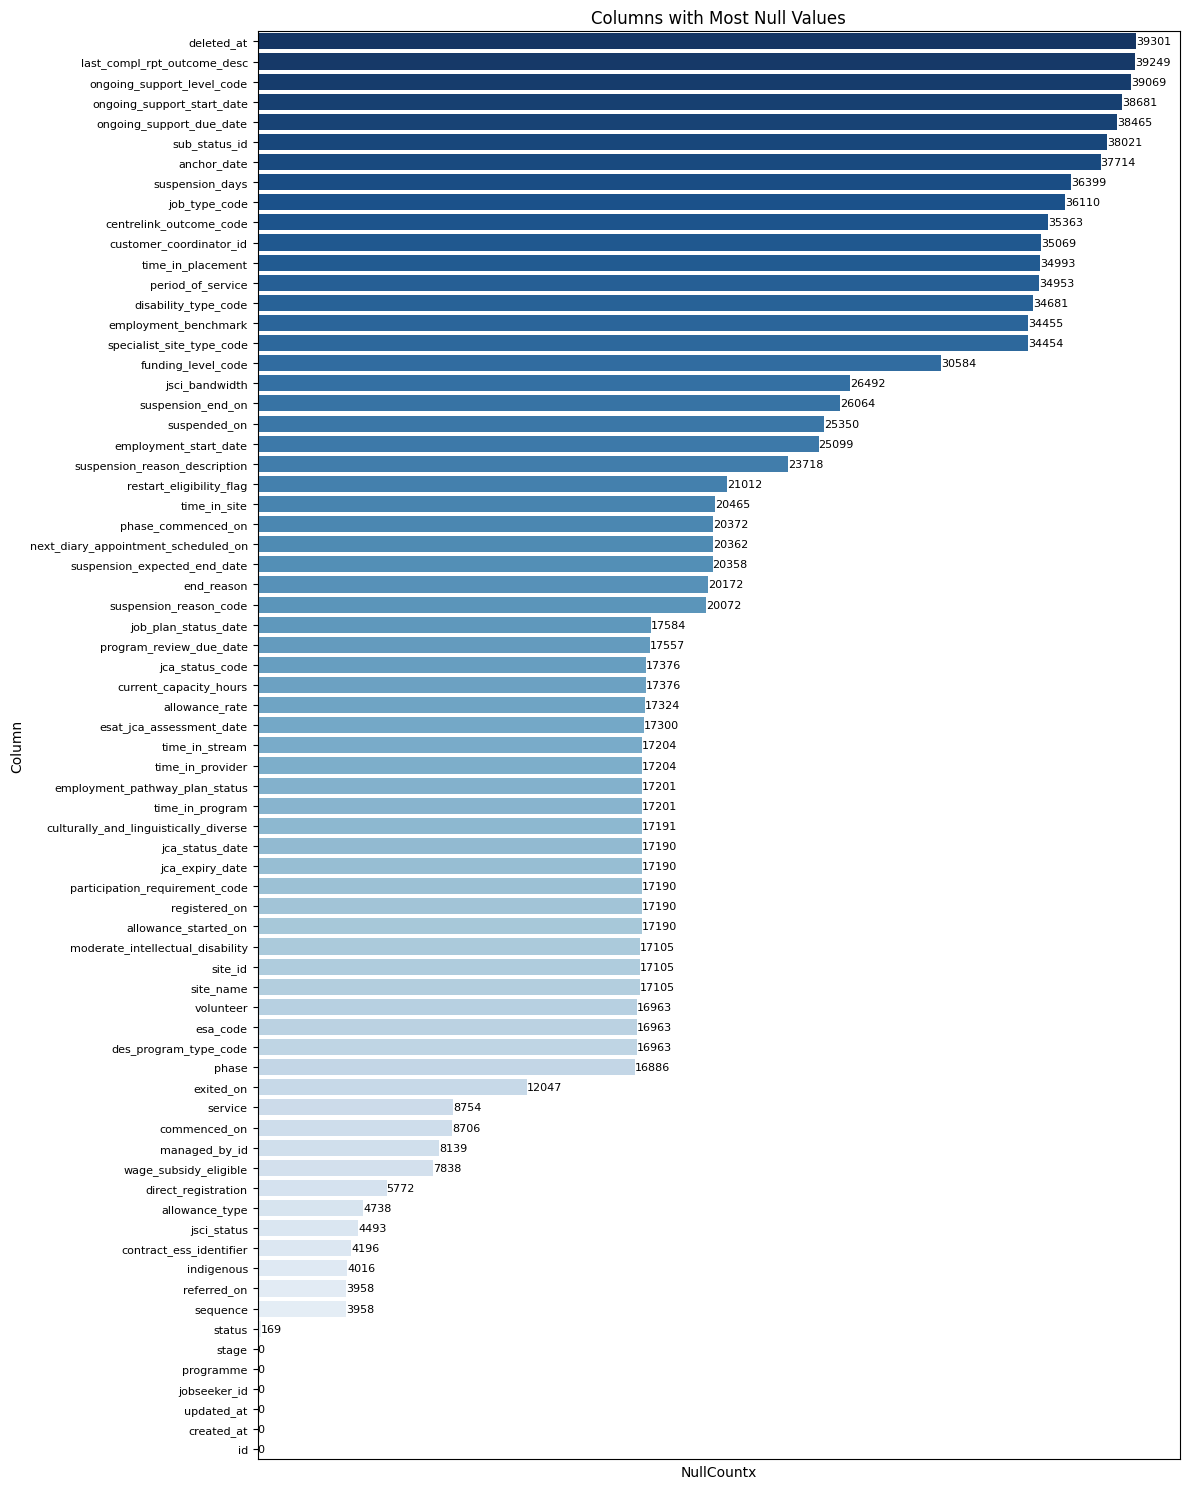

In [96]:
# 获取缺失值最多的前 100 列
top_nulls = ab_sp_df.isnull().sum().sort_values(ascending=False).head(100)

# 转换为 DataFrame 以便 Seaborn 使用
top_nulls_df = top_nulls.reset_index()
top_nulls_df.columns = ['Column', 'NullCountx']

# 设置图形大小
plt.figure(figsize=(12, 15))

# 使用 Seaborn 绘制横向条形图
sns.barplot(data=top_nulls_df, x='NullCountx', y='Column', palette='Blues_r')

# 添加标题和标签
plt.title('Columns with Most Null Values')
# plt.xlabel('Number of Null Values')
plt.xticks([])  # 去除 x 轴刻度
plt.yticks(fontsize=8)  # 调整 y 轴标签字体大小

# 添加每个条形的数值标签
for i, value in enumerate(top_nulls_df['NullCountx']):
    plt.text(value, i, str(value), va='center', fontsize=8)

plt.tight_layout()
plt.show()


In [97]:
# 第一步：合并 ab_sp_df 和 ab_j_df
merged_df = ab_sp_df.merge(
    ab_j_df,
    left_on='jobseeker_id',
    right_on='id',
    how='left',
    suffixes=('', '_j')
)

# 合并 ab_rs_df
merged_df = merged_df.merge(
    ab_rs_df,
    left_on='referral_source_id',
    right_on='id',
    how='left',
    suffixes=('', '_rs')
)

# 合并 ab_u_df
merged_df = merged_df.merge(
    ab_u_df,
    left_on='customer_coordinator_id',
    right_on='id',
    how='left',
    suffixes=('', '_u')
)


In [98]:
# 第二步：筛选符合条件的记录
filtered_df = merged_df[
    (merged_df['deleted_at'].isnull()) 
    # & (merged_df['programme'] == 'DES')
]


In [99]:
filtered_df.shape

(39301, 182)

In [100]:
# 第三步：选取字段并重命名
selected_columns = [
    'id', 'jobseeker_id', 'ess_identifier', 'first_name', 'middle_names', 'last_name',
    'stage', 'service', 'status', 'phase', 'jsci_status', 'referred_on', 'suspension_reason_code',
    'site_id', 'site_id_j', 'referral_source_id', 'exited_on', 'end_reason',
    'specialist_site_type_code', 'job_plan_status_date', 'direct_registration', 'volunteer',
    'moderate_intellectual_disability', 'programme', 'employment_pathway_plan_status',
    'managed_by_id', 'next_diary_appointment_scheduled_on', 'name', 'contract_ess_identifier',
    'ongoing_support_level_code', 'date_of_birth'
]

# 过滤掉不存在的列
selected_columns = [col for col in selected_columns if col in filtered_df.columns]

result_df = filtered_df[selected_columns].copy()

# 重命名 site_id 字段
result_df.rename(columns={
    'site_id': 'sp_site_id',
    'site_id_j': 'js_site_id'
}, inplace=True)

# 拼接客户协调员姓名
if 'first_name_u' in filtered_df.columns and 'last_name_u' in filtered_df.columns:
    result_df['Customer_Coordinator'] = (
        filtered_df['first_name_u'].fillna('') + ' ' + filtered_df['last_name_u'].fillna('')
    )


In [101]:
result_df['programme'].value_counts()

DES          26061
WFA          13230
jobActive       10
Name: programme, dtype: int64

In [102]:
has_duplicates = result_df['id'].duplicated().any()
has_duplicates

False

In [103]:
# 检查是否有重复的 id，并输出重复的值和次数
if 'id' in result_df.columns:
    id_counts = result_df['id'].value_counts()
    duplicate_ids = id_counts[id_counts > 1]

    if not duplicate_ids.empty:
        print("以下是重复的 id 及其出现次数：")
        print(duplicate_ids)
    else:
        result_df.set_index('id', inplace=True)
        print("没有重复的 id,已将 'id' 设为索引。")
else:
    print("DataFrame 中没有 'id' 列。")


没有重复的 id,已将 'id' 设为索引。


In [104]:
result_df

,jobseeker_id,ess_identifier,first_name,middle_names,last_name,stage,service,status,phase,jsci_status,...,moderate_intellectual_disability,programme,employment_pathway_plan_status,managed_by_id,next_diary_appointment_scheduled_on,name,contract_ess_identifier,ongoing_support_level_code,date_of_birth,Customer_Coordinator
id,,,,,,,,,,,,,,,,,,,,,
10,10,82960,JOHN,SILAS JACKSON,KENNEDY,exited,ess,exited,PPS,Active,...,False,DES,Approved,240.0,NaN,Centrelink,0212881B,NaN,1997-02-12 00:00:00,
1,1,4194710,GINA,LEORA,COLLINS,referred,ess3,exited,EA,Active,...,False,DES,Pending Approval,NaN,NaN,NaN,0212879H,NaN,2001-04-05 00:00:00,
86,86,9427370008,JODIE,MICHELLE,HARDIE,referred,dms3,transferred,EA,Active,...,False,DES,Approved,176.0,2021-01-18,Centrelink,0212831C,NaN,1978-01-31 00:00:00,
106,106,7272646909.0,GEOFFREY,WAYNE,LARSON,referred,dms5,exited,PPS,Active,...,False,DES,Approved,NaN,NaN,NaN,0212795D,NaN,1957-07-16 00:00:00,
35,35,7591067019,VICKY,NaN,ANAGNOSTOPOULOS,referred,dms5,exited,PPS,Active,...,False,DES,Approved,NaN,NaN,NaN,0212820K,NaN,2000-06-15 00:00:00,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39609,39266,5484790,SALMAN,SALEM,ALENIZY,referred,dms4,commenced,EA,Active,...,False,DES,Approved,216.0,2025-07-30,Centrelink,0212817E,NaN,2001-12-06 00:00:00,Shannon Orr
39633,39290,7806189709,MADDIE,LOUISE,FROST,referred,NaN,commenced,NaN,Active,...,NaN,WFA,NaN,648.0,2025-08-12,NaN,0213439C,NaN,1993-08-30 00:00:00,
39737,39394,19317210,RICKI,ANN,ROWE,referred,NaN,pending,NaN,Active,...,NaN,WFA,NaN,454.0,2025-08-07,NaN,0213438B,NaN,2004-03-26 00:00:00,


In [105]:
print(result_df.index.name)

id


In [106]:
# 标记原始数据中哪些是缺失值（例如 NaN 或空字符串）
null_mask = result_df['date_of_birth'].isna() | (result_df['date_of_birth'].astype(str).str.strip() == '')

# 标记哪些是格式错误导致转换失败
converted_dates = pd.to_datetime(result_df['date_of_birth'], errors='coerce')
invalid_mask = converted_dates.isna()

# 合并两种情况
combined_mask = null_mask | invalid_mask

# 提取原始值并统计频次
invalid_date_values = result_df.loc[combined_mask, 'date_of_birth']
invalid_date_counts = invalid_date_values.value_counts(dropna=False)

# 打印结果
print(invalid_date_counts)


NaN                    687
0001-01-01 00:00:00    348
0971-09-03 00:00:00      1
0967-12-07 00:00:00      1
1075-05-10 00:00:00      1
2970-10-20 00:00:00      1
2961-07-25 00:00:00      1
Name: date_of_birth, dtype: int64


In [107]:
result_df['date_of_birth'] = pd.to_datetime(
    result_df['date_of_birth'], errors='coerce'
).dt.strftime('%d/%m/%Y')

In [108]:
invalid_dates = result_df['date_of_birth'].isna().sum()
print(f"Invalid date entries: {invalid_dates}")

Invalid date entries: 1040


In [109]:
# result_df.loc[140]
result_df[result_df['ess_identifier'] == '998300'].squeeze()

jobseeker_id                                         51
ess_identifier                                   998300
first_name                                        CARLA
middle_names                                       JANE
last_name                                     BORTHWICK
stage                                          referred
service                                            dms3
status                                           exited
phase                                                EA
jsci_status                                      Active
referred_on                                  2019-11-11
suspension_reason_code                              NaN
sp_site_id                                         26.0
js_site_id                                           26
referral_source_id                                  NaN
exited_on                                    2019-12-09
end_reason                                          FTD
specialist_site_type_code                       